In [1]:
import ee 
import pandas as pd
import geopandas as gpd

ee.Initialize()

csv_file = '/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/mapbiomas_85k_col2_1_points_english.csv'
df_points = pd.read_csv(csv_file)


Point ID: 37464
Location: Lat -8.8886, Lon -60.7440
Biome: Amazon

Fetching daily NDVI time series from 2000-01-01 to 2023-12-31...
Found 702 Landsat images with <50% cloud cover
Fetching NDVI values from Earth Engine...
Found 702 Landsat images with <50% cloud cover
Fetching NDVI values from Earth Engine...
Retrieved 244 valid NDVI observations
Retrieved 244 valid NDVI observations

Fetching Landsat RGB imagery (100x100 pixels)...

Fetching Landsat RGB imagery (100x100 pixels)...
  2004: ✓ (14 images)
  2004: ✓ (14 images)
  2005: ✓ (16 images)
  2005: ✓ (16 images)
  2006: ✓ (19 images)
  2006: ✓ (19 images)
  2007: ✓ (15 images)
  2007: ✓ (15 images)
  2008: ✓ (14 images)
  2008: ✓ (14 images)


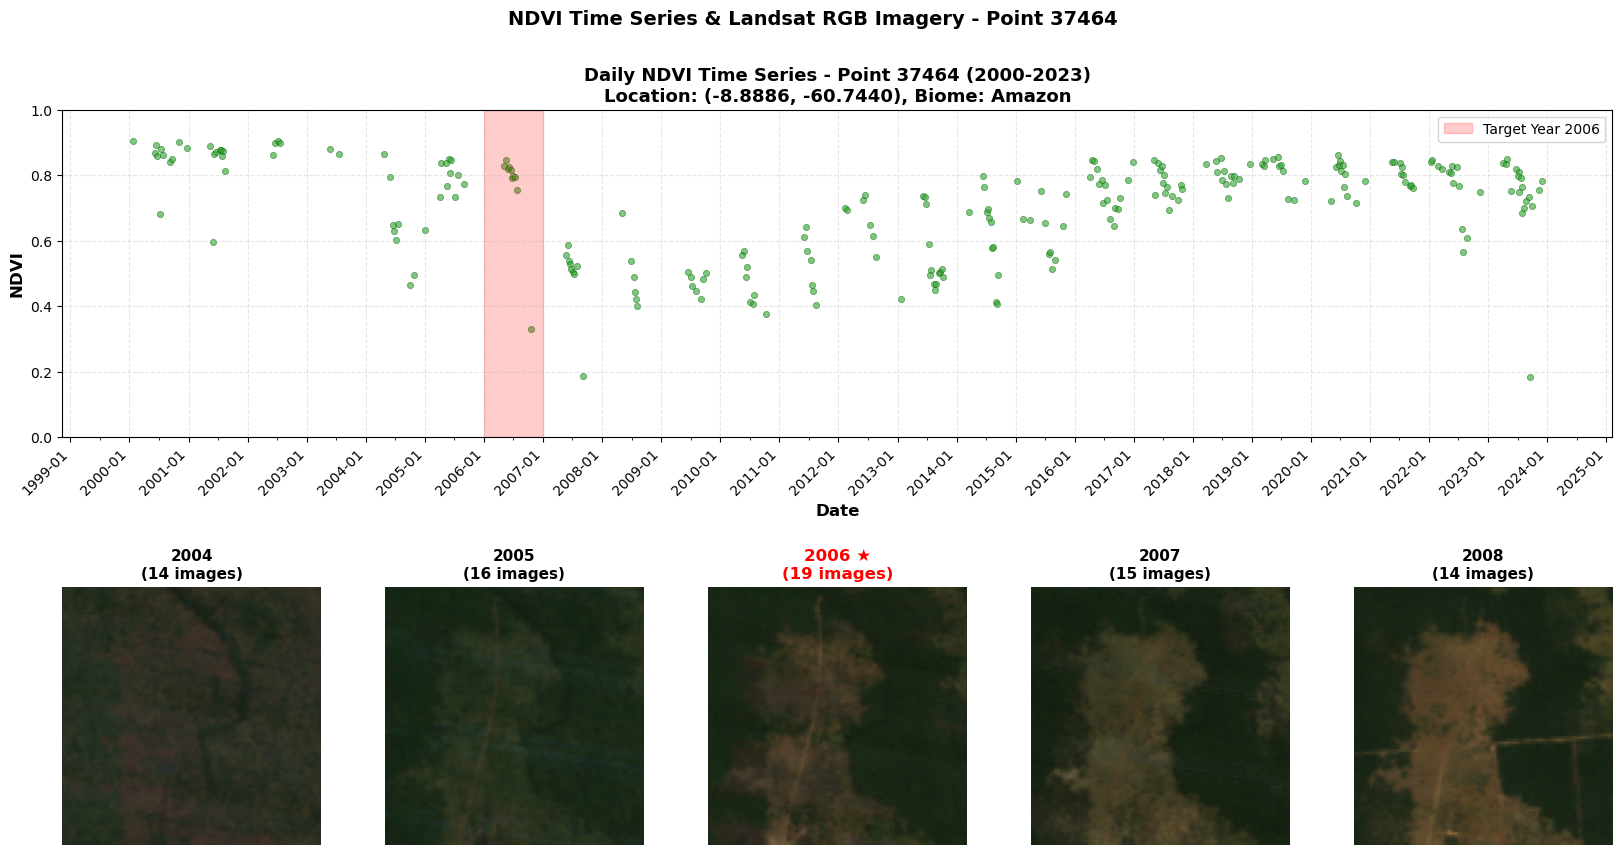


NDVI Statistics:
  Overall Mean NDVI: 0.707
  Overall Min NDVI: 0.183 (Date: 2023-09-18)
  Overall Max NDVI: 0.904 (Date: 2000-01-22)

  Target Year 2006 Mean NDVI: 0.761
  Target Year 2006 Min NDVI: 0.330
  Target Year 2006 Max NDVI: 0.848
  Number of observations in 2006: 10


In [7]:
# Get daily NDVI time series for a specific point and year range
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# User inputs
point_id = 37464  # Replace with your point ID
target_year = 2006  # Replace with your target year

start_year = 2000
end_year = 2023

# Get the point from df_points
point_data = df_points[df_points['TARGETID'] == point_id]

if len(point_data) == 0:
    print(f"Point ID {point_id} not found in validation data.")
else:
    point = point_data.iloc[0]
    lat = point['LAT']
    lon = point['LON']
    biome = point.get('BIOMA_250K', 'Unknown')
    
    print(f"Point ID: {point_id}")
    print(f"Location: Lat {lat:.4f}, Lon {lon:.4f}")
    print(f"Biome: {biome}")
    
    # Create Earth Engine point
    ee_point = ee.Geometry.Point([lon, lat])
    
    # Define year range (2000 to 2023)

    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    
    print(f"\nFetching daily NDVI time series from {start_date} to {end_date}...")
    
    # Combine all available Landsat collections
    try:
        # Landsat 5
        l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(ee_point) \
            #.filter(ee.Filter.lt('CLOUD_COVER', 50))
        
        # Landsat 7
        l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(ee_point) \
            #.filter(ee.Filter.lt('CLOUD_COVER', 50))
        
        # Landsat 8
        l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(ee_point) \
            #.filter(ee.Filter.lt('CLOUD_COVER', 50))
        
        # Landsat 9
        l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(ee_point) \
            .filter(ee.Filter.lt('CLOUD_COVER', 50))
        
        # Preprocessing function for Landsat 4/5/7 Collection 2
        def prepareL4L5L7Col2(image):
            bandList = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','ST_B6']
            nameList = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP']
            subBand = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']
            
            opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
            thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
            scaled = opticalBands.addBands(thermalBand, None, True).select(bandList).rename(nameList)
            
            validQA = [5440, 5504]  # 5442, 5506
            
            mask1 = image.select(['QA_PIXEL']).remap(
                validQA, ee.List.repeat(1, len(validQA)), 0)
            mask2 = image.select('QA_RADSAT').eq(0)
            mask3 = scaled.select(subBand).reduce(ee.Reducer.min()).gt(0)
            mask4 = scaled.select(subBand).reduce(ee.Reducer.max()).lt(1)
            mask5 = image.select("SR_ATMOS_OPACITY").unmask(-1).lt(300)
            
            return image.addBands(scaled).updateMask(
                mask1.And(mask2).And(mask3).And(mask4).And(mask5))
        
        # Preprocessing function for Landsat 8/9 Collection 2
        def prepareL8Col2(image):
            bandList = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']
            nameList = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP']
            subBand = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']
            
            opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
            thermalBand = image.select('ST_B10').multiply(0.00341802).add(149.0)
            scaled = opticalBands.addBands(thermalBand, None, True).select(bandList).rename(nameList)
            
            validTOA = [2, 4, 32, 66, 68, 96, 100, 130, 132, 160, 164, 64, 128]
            validQA = [21824, 21888, 21952]  # 21826, 21890
            
            mask1 = image.select(['QA_PIXEL']).remap(
                validQA, ee.List.repeat(1, len(validQA)), 0)
            mask2 = image.select('QA_RADSAT').eq(0)
            mask3 = scaled.select(subBand).reduce(ee.Reducer.min()).gt(0)
            mask4 = scaled.select(subBand).reduce(ee.Reducer.max()).lt(1)
            mask5 = image.select(['SR_QA_AEROSOL']).remap(
                validTOA, ee.List.repeat(1, len(validTOA)), 0)
            
            return image.addBands(scaled).updateMask(
                mask1.And(mask2).And(mask3).And(mask4).And(mask5))
        
        # Function to calculate NDVI for Landsat 5/7
        def calc_ndvi_57(image):
            # Apply preprocessing and calculate NDVI
            processed = prepareL4L5L7Col2(image)
            ndvi = processed.select(['NIR', 'RED']).normalizedDifference().rename('NDVI')
            return processed.addBands(ndvi).set('system:time_start', image.get('system:time_start'))
        
        # Function to calculate NDVI for Landsat 8/9
        def calc_ndvi_89(image):
            # Apply preprocessing and calculate NDVI
            processed = prepareL8Col2(image)
            ndvi = processed.select(['NIR', 'RED']).normalizedDifference().rename('NDVI')
            return processed.addBands(ndvi).set('system:time_start', image.get('system:time_start'))
        
        # Apply NDVI calculation
        l5_ndvi = l5.map(calc_ndvi_57)
        l7_ndvi = l7.map(calc_ndvi_57)
        l8_ndvi = l8.map(calc_ndvi_89)
        # l9_ndvi = l9.map(calc_ndvi_89)
        
        # Merge all collections
        all_landsat = l5_ndvi.merge(l7_ndvi).merge(l8_ndvi).select('NDVI')#.merge(l9_ndvi).select('NDVI')
        
        # Get collection size
        n_images = all_landsat.size().getInfo()
        print(f"Found {n_images} Landsat images with <50% cloud cover")
        
        if n_images == 0:
            print("No images found. Try increasing cloud cover threshold or checking date range.")
        else:
            # Sample NDVI at the point for all images
            def sample_ndvi(image):
                ndvi = image.reduceRegion(
                    reducer=ee.Reducer.first(),
                    geometry=ee_point,
                    scale=30
                ).get('NDVI')
                return ee.Feature(None, {
                    'date': image.date().format('YYYY-MM-dd'),
                    'timestamp': image.date().millis(),
                    'ndvi': ndvi
                })
            
            # Sample all images
            samples = all_landsat.map(sample_ndvi)
            
            # Get the data
            print("Fetching NDVI values from Earth Engine...")
            sample_list = samples.getInfo()['features']
            
            # Extract dates and NDVI values
            dates = []
            ndvi_values = []
            
            for sample in sample_list:
                props = sample['properties']
                if props['ndvi'] is not None:
                    date_str = props['date']
                    dates.append(datetime.strptime(date_str, '%Y-%m-%d'))
                    ndvi_values.append(props['ndvi'])
            
            print(f"Retrieved {len(dates)} valid NDVI observations")
            
            if len(dates) > 0:
                # Sort by date
                sorted_indices = np.argsort(dates)
                dates = [dates[i] for i in sorted_indices]
                ndvi_values = [ndvi_values[i] for i in sorted_indices]
                
                # Create figure with NDVI time series and Landsat imagery
                fig = plt.figure(figsize=(20, 10))
                gs = fig.add_gridspec(2, 5, height_ratios=[1, 1], hspace=0.35, wspace=0.25)
                
                # Plot NDVI time series (top row, spanning all columns)
                ax = fig.add_subplot(gs[0, :])
                ax.scatter(dates, ndvi_values, s=20, color='#2ca02c', alpha=0.6, edgecolors='darkgreen', linewidth=0.5)
                
                # Add target year vertical line
                target_start = datetime(target_year, 1, 1)
                target_end = datetime(target_year, 12, 31)
                ax.axvspan(target_start, target_end, alpha=0.2, color='red', label=f'Target Year {target_year}')
                
                ax.set_xlabel('Date', fontsize=12, fontweight='bold')
                ax.set_ylabel('NDVI', fontsize=12, fontweight='bold')
                ax.set_title(f'Daily NDVI Time Series - Point {point_id} ({start_year}-{end_year})\n'
                            f'Location: ({lat:.4f}, {lon:.4f}), Biome: {biome}', 
                            fontsize=13, fontweight='bold')
                ax.grid(True, alpha=0.3, linestyle='--')
                ax.set_ylim([0, 1])
                ax.legend()
                
                # Format x-axis
                import matplotlib.dates as mdates
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                ax.xaxis.set_major_locator(mdates.YearLocator())
                ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 7)))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
                
                # Get Landsat RGB imagery for years around target_year (including target year)
                print("\nFetching Landsat RGB imagery (100x100 pixels)...")
                
                # Create region of interest: 100x100 pixels = 3000m x 3000m at 30m resolution
                buffer_distance = 1500  # meters (50 pixels * 30m)
                roi = ee_point.buffer(buffer_distance).bounds()
                
                # Include target year in the imagery display
                imagery_years = [target_year - 2, target_year - 1, target_year, target_year + 1, target_year + 2]
                
                for idx, year in enumerate(imagery_years):
                    ax_img = fig.add_subplot(gs[1, idx])
                    
                    try:
                        # Select appropriate Landsat collection and bands
                        if year < 2013:
                            # Landsat 5/7: RGB = B3, B2, B1
                            collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                                .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')) \
                                .filterDate(f'{year}-01-01', f'{year}-12-31') \
                                .filterBounds(ee_point) \
                                .filter(ee.Filter.lt('CLOUD_COVER', 30))
                            rgb_bands = ['SR_B3', 'SR_B2', 'SR_B1']
                        else:
                            # Landsat 8/9: RGB = B4, B3, B2
                            collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                                .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')) \
                                .filterDate(f'{year}-01-01', f'{year}-12-31') \
                                .filterBounds(ee_point) \
                                .filter(ee.Filter.lt('CLOUD_COVER', 30))
                            rgb_bands = ['SR_B4', 'SR_B3', 'SR_B2']
                        
                        n_imgs = collection.size().getInfo()
                        
                        if n_imgs > 0:
                            # Get median composite
                            img = collection.median().select(rgb_bands)
                            
                            # Apply scaling factors for surface reflectance
                            img = img.multiply(0.0000275).add(-0.2)
                            
                            # Get thumbnail URL
                            url = img.getThumbURL({
                                'region': roi.getInfo()['coordinates'],
                                'dimensions': 100,
                                'format': 'png',
                                'min': 0,
                                'max': 0.3
                            })
                            
                            # Download and display image
                            import requests
                            from PIL import Image
                            from io import BytesIO
                            
                            response = requests.get(url)
                            img_data = Image.open(BytesIO(response.content))
                            
                            ax_img.imshow(img_data)
                            # Highlight target year with different style
                            if year == target_year:
                                ax_img.set_title(f'{year} ★\n({n_imgs} images)', 
                                               fontsize=12, fontweight='bold', color='red')
                                # Add red border for target year
                                for spine in ax_img.spines.values():
                                    spine.set_edgecolor('red')
                                    spine.set_linewidth(3)
                            else:
                                ax_img.set_title(f'{year}\n({n_imgs} images)', fontsize=11, fontweight='bold')
                            ax_img.axis('off')
                            
                            print(f"  {year}: ✓ ({n_imgs} images)")
                        else:
                            ax_img.text(0.5, 0.5, f'No clear\nimagery\n({year})', 
                                       ha='center', va='center', fontsize=10, transform=ax_img.transAxes)
                            ax_img.set_title(f'{year}', fontsize=11, fontweight='bold')
                            ax_img.axis('off')
                            print(f"  {year}: No imagery available")
                            
                    except Exception as e:
                        ax_img.text(0.5, 0.5, f'Error\n{year}', 
                                   ha='center', va='center', fontsize=10, transform=ax_img.transAxes)
                        ax_img.set_title(f'{year}', fontsize=11, fontweight='bold')
                        ax_img.axis('off')
                        print(f"  {year}: Error - {str(e)[:50]}")
                
                plt.suptitle(f'NDVI Time Series & Landsat RGB Imagery - Point {point_id}', 
                            fontsize=14, fontweight='bold', y=0.98)
                plt.show()
                
                # Calculate statistics
                ndvi_array = np.array(ndvi_values)
                target_year_mask = [(d.year == target_year) for d in dates]
                target_year_ndvi = ndvi_array[target_year_mask]
                
                print(f"\n{'='*80}")
                print(f"NDVI Statistics:")
                print(f"  Overall Mean NDVI: {np.mean(ndvi_array):.3f}")
                print(f"  Overall Min NDVI: {np.min(ndvi_array):.3f} (Date: {dates[np.argmin(ndvi_array)].strftime('%Y-%m-%d')})")
                print(f"  Overall Max NDVI: {np.max(ndvi_array):.3f} (Date: {dates[np.argmax(ndvi_array)].strftime('%Y-%m-%d')})")
                
                if len(target_year_ndvi) > 0:
                    print(f"\n  Target Year {target_year} Mean NDVI: {np.mean(target_year_ndvi):.3f}")
                    print(f"  Target Year {target_year} Min NDVI: {np.min(target_year_ndvi):.3f}")
                    print(f"  Target Year {target_year} Max NDVI: {np.max(target_year_ndvi):.3f}")
                    print(f"  Number of observations in {target_year}: {len(target_year_ndvi)}")
                
                print(f"{'='*80}")
            else:
                print("\nNo valid NDVI data available for the specified time period.")
                
    except Exception as e:
        print(f"Error fetching data: {e}")



Running CCDC Analysis for Point 37464

Preparing Landsat collections for CCDC...
Total images for CCDC: 702
Running CCDC algorithm (this may take a moment)...
Extracting time series data...
Total images for CCDC: 702
Running CCDC algorithm (this may take a moment)...
Extracting time series data...
Extracting segment boundaries...
Extracting segment boundaries...
Found 5 CCDC segments
Found 5 CCDC segments


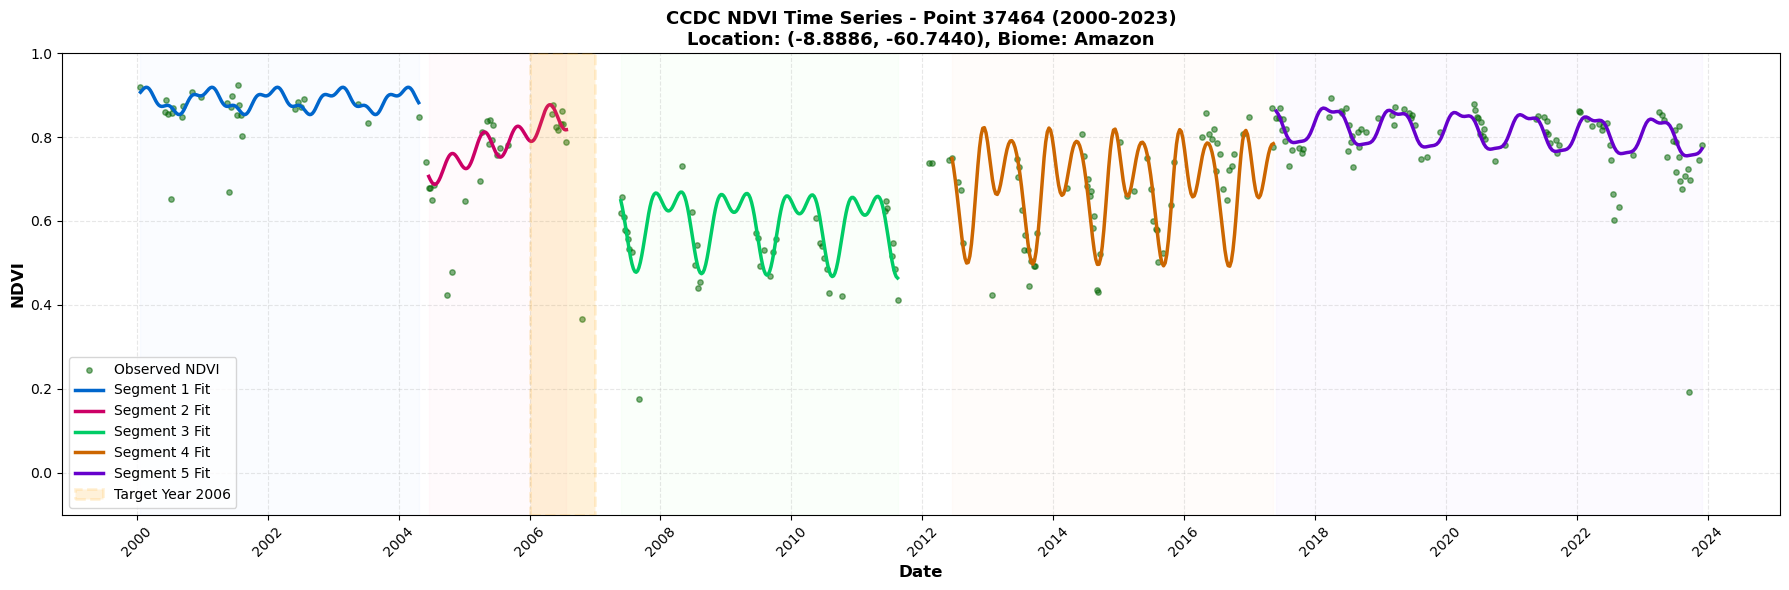


CCDC Segment Information:
Segment 1: 2000-01-22 to 2004-04-22 (1552 days, 101 obs, mean NDVI: 0.854, RMSE: 0.178)
Segment 2: 2004-06-17 to 2006-07-25 (768 days, 63 obs, mean NDVI: 0.756, RMSE: 0.187)
Segment 3: 2007-05-25 to 2011-08-16 (1543 days, 113 obs, mean NDVI: 0.532, RMSE: 0.097)
Segment 4: 2012-06-15 to 2017-05-12 (1792 days, 150 obs, mean NDVI: 0.662, RMSE: 0.082)
Segment 5: 2017-05-28 to 2023-11-29 (2375 days, 230 obs, mean NDVI: 0.794, RMSE: 0.109)

Target Year 2006 Statistics:
  Observations: 28
  Mean NDVI (observed): 0.783
  Mean NDVI (fitted): 0.392
  RMSE: 0.290


In [13]:
# CCDC Analysis for NDVI time series
import math
from typing import List, Tuple

# CCDC parameters
BREAKPOINT_BANDS = ['GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']
TMASK_BANDS = ['GREEN', 'SWIR2']
CCDC_DATE_FORMAT = 1  # fractional years
CCDC_LAMBDA = 20 / 10000.0
CCDC_MAX_ITER = 10000

def add_ndvi_band(image):
    """Add NDVI band to image that already has standardized band names."""
    ndvi = image.normalizedDifference(['NIR', 'RED']).rename('NDVI')
    return image.addBands(ndvi)

def convert_date_to_fractional_year(date):
    """Convert EE date to fractional year."""
    year = ee.Number(date.get('year'))
    fractional = date.difference(ee.Date.fromYMD(year, 1, 1), 'year')
    return year.add(fractional)

def date_to_segment(t, fits):
    """Find which CCDC segment a given time belongs to."""
    t_start = ee.Array(fits.get('tStart'))
    t_end = ee.Array(fits.get('tEnd'))
    mask = t_start.lte(t).And(t_end.gte(t))
    return ee.List(mask.toList()).indexOf(1)

def harmonic_fit(t, coef):
    """Calculate CCDC harmonic fit value at time t."""
    pi2 = 2.0 * math.pi
    omega = pi2 #/ 365.25  # for fractional years
    return (
        coef.get([0])
        .add(coef.get([1]).multiply(t))
        .add(coef.get([2]).multiply(t.multiply(omega).cos()))
        .add(coef.get([3]).multiply(t.multiply(omega).sin()))
        .add(coef.get([4]).multiply(t.multiply(omega * 2).cos()))
        .add(coef.get([5]).multiply(t.multiply(omega * 2).sin()))
        .add(coef.get([6]).multiply(t.multiply(omega * 3).cos()))
        .add(coef.get([7]).multiply(t.multiply(omega * 3).sin()))
    )

def fractional_year_to_datetime(value):
    """Convert fractional year to datetime."""
    if value is None:
        return None
    year = int(math.floor(value))
    frac = value - year
    start = datetime(year, 1, 1)
    end = datetime(year + 1, 1, 1)
    return start + (end - start) * frac

def run_ccdc_analysis(point_geom, start_date, end_date, band='NDVI'):
    """Run CCDC analysis and return time series with fitted values."""
    
    # Use existing preprocessed collections
    print("Preparing Landsat collections for CCDC...")
    
    # Standard bands to keep for CCDC
    standard_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']
    
    # Create collections with preprocessing (reuse existing functions)
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(point_geom) \
        .map(prepareL4L5L7Col2) \
        .map(add_ndvi_band) \
        .select(standard_bands)  # Keep only standardized bands
    
    l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(point_geom) \
        .map(prepareL4L5L7Col2) \
        .map(add_ndvi_band) \
        .select(standard_bands)  # Keep only standardized bands
    
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(point_geom) \
        .map(prepareL8Col2) \
        .map(add_ndvi_band) \
        .select(standard_bands)  # Keep only standardized bands
    
    # Merge collections (now all have the same bands)
    collection = l5.merge(l7).merge(l8)
    
    n_imgs = collection.size().getInfo()
    print(f"Total images for CCDC: {n_imgs}")
    
    if n_imgs == 0:
        print("No images available for CCDC analysis")
        return None, None, None
    
    # Run CCDC algorithm
    print("Running CCDC algorithm (this may take a moment)...")
    ccdc_params = {
        'collection': collection,
        'breakpointBands': BREAKPOINT_BANDS,
        'tmaskBands': TMASK_BANDS,
        'dateFormat': CCDC_DATE_FORMAT,
        'lambda': CCDC_LAMBDA,
        'maxIterations': CCDC_MAX_ITER,
        'minObservations': 6,
        'chiSquareProbability': 0.99,
        'minNumOfYearsScaler': 1.33
    }
    ccdc_result = ee.Algorithms.TemporalSegmentation.Ccdc(**ccdc_params)
    
    # Get CCDC coefficients at point
    projection = ee.Projection('EPSG:4326').atScale(30)
    fits = ee.Dictionary(
        ccdc_result.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point_geom,
            crs=projection
        )
    )
    
    # Augment collection with fit values
    def augment_with_fit(img):
        img = ee.Image(img)
        time = convert_date_to_fractional_year(img.date())
        segment = date_to_segment(time, fits)
        
        # Get observed value
        value = img.select(band).reduceRegion(
            ee.Reducer.first(), 
            geometry=point_geom, 
            crs=projection
        ).get(band)
        
        # Get fitted value
        coef = ee.Algorithms.If(
            ee.Number(segment).add(1),
            ee.Array(fits.getArray(f'{band}_coefs'))
                .slice(0, segment, ee.Number(segment).add(1))
                .project([1]),
            ee.Array([0, 0, 0, 0, 0, 0, 0, 0])
        )
        coef = ee.Array(coef)
        fit = harmonic_fit(time, coef)
        
        return img.set({
            'value': value,
            'fitTime': time,
            'fit': fit,
            'segment': segment,
            'dateString': img.date().format('YYYY-MM-dd')
        })
    
    series = collection.sort('system:time_start').map(augment_with_fit)
    
    # Extract to lists
    print("Extracting time series data...")
    reducer = ee.Reducer.toList(4, 4)
    table = ee.List(
        series.reduceColumns(reducer, ['dateString', 'value', 'fit', 'segment'])
            .get('list')
    ).getInfo()
    
    # Convert to DataFrame
    df_ccdc = pd.DataFrame(table, columns=['date', 'ndvi', 'fit', 'segment'])
    df_ccdc['date'] = pd.to_datetime(df_ccdc['date'])
    df_ccdc = df_ccdc.sort_values('date')
    
    # Extract segment boundaries
    print("Extracting segment boundaries...")
    t_start = ee.Array(fits.get('tStart')).toList().getInfo()
    t_end = ee.Array(fits.get('tEnd')).toList().getInfo()
    
    segments = []
    for i, (start_val, end_val) in enumerate(zip(t_start, t_end)):
        if start_val is not None and end_val is not None:
            start_dt = fractional_year_to_datetime(start_val)
            end_dt = fractional_year_to_datetime(end_val)
            if start_dt and end_dt and end_dt > start_dt:
                segments.append((i, start_dt, end_dt))
    
    print(f"Found {len(segments)} CCDC segments")
    
    return df_ccdc, segments, fits

# Run CCDC analysis for the current point
print(f"\n{'='*80}")
print(f"Running CCDC Analysis for Point {point_id}")
print(f"{'='*80}\n")

try:
    df_ccdc, segments, ccdc_fits = run_ccdc_analysis(
        ee_point, 
        f'{start_year}-01-01', 
        f'{end_year}-12-31',
        band='NDVI'
    )
    
    if df_ccdc is not None:
        # Plot CCDC results
        fig, ax = plt.subplots(figsize=(18, 6))
        
        # Plot observed NDVI
        ax.scatter(df_ccdc['date'], df_ccdc['ndvi'], s=15, color='darkgreen', 
                   alpha=0.5, label='Observed NDVI', zorder=2)
        
        # Plot harmonic curves for each segment
        segment_colors_line = ['#0066cc', '#cc0066', '#00cc66', '#cc6600', '#6600cc', '#cc9900']
        
        for seg_idx, start_dt, end_dt in segments:
            # Generate dense time points for smooth curve
            n_points = 200
            time_range = pd.date_range(start=start_dt, end=end_dt, periods=n_points)
            
            # Convert to fractional years
            fractional_times = []
            for t in time_range:
                year = t.year
                year_start = datetime(year, 1, 1)
                year_end = datetime(year + 1, 1, 1)
                frac = (t - year_start) / (year_end - year_start)
                fractional_times.append(year + frac)
            
            # Get coefficients for this segment from Earth Engine
            try:
                coefs_array = ee.Array(ccdc_fits.getArray('NDVI_coefs')).slice(0, seg_idx, seg_idx + 1).project([1]).getInfo()
                
                # Calculate harmonic fit values
                pi2 = 2.0 * math.pi
                omega = pi2 #/ 365.25
                
                fit_values = []
                for t in fractional_times:
                    # Harmonic model: intercept + slope*t + cos/sin terms
                    fit_val = (
                        coefs_array[0] +
                        coefs_array[1] * t +
                        coefs_array[2] * np.cos(omega * t) +
                        coefs_array[3] * np.sin(omega * t) +
                        coefs_array[4] * np.cos(2 * omega * t) +
                        coefs_array[5] * np.sin(2 * omega * t) +
                        coefs_array[6] * np.cos(3 * omega * t) +
                        coefs_array[7] * np.sin(3 * omega * t)
                    )
                    fit_values.append(fit_val)
                
                # Plot the harmonic curve for this segment
                color = segment_colors_line[seg_idx % len(segment_colors_line)]
                ax.plot(time_range, fit_values, color=color, linewidth=2.5, 
                       label=f'Segment {seg_idx + 1} Fit' if seg_idx < 6 else None, zorder=3)
                
            except Exception as e:
                print(f"Warning: Could not plot harmonic curve for segment {seg_idx + 1}: {e}")
        
        # Color segment backgrounds
        segment_colors_bg = ['#e6f2ff', '#ffe6f2', '#e6ffe6', '#fff2e6', '#f2e6ff', '#fff9e6']
        for idx, start_dt, end_dt in segments:
            color = segment_colors_bg[idx % len(segment_colors_bg)]
            ax.axvspan(start_dt, end_dt, alpha=0.2, color=color, zorder=1)
        
        # Highlight target year
        if target_year:
            target_start_dt = datetime(target_year, 1, 1)
            target_end_dt = datetime(target_year, 12, 31)
            ax.axvspan(target_start_dt, target_end_dt, alpha=0.15, color='orange', 
                      edgecolor='red', linewidth=2, linestyle='--',
                      label=f'Target Year {target_year}', zorder=4)
        
        ax.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax.set_ylabel('NDVI', fontsize=12, fontweight='bold')
        ax.set_title(f'CCDC NDVI Time Series - Point {point_id} ({start_year}-{end_year})\n'
                    f'Location: ({lat:.4f}, {lon:.4f}), Biome: {biome}', 
                    fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_ylim([-0.1, 1.0])
        ax.legend(loc='best', fontsize=10)
        
        # Format x-axis
        import matplotlib.dates as mdates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print segment information
        print(f"\n{'='*80}")
        print(f"CCDC Segment Information:")
        print(f"{'='*80}")
        for idx, start_dt, end_dt in segments:
            duration_days = (end_dt - start_dt).days
            segment_data = df_ccdc[
                (df_ccdc['date'] >= start_dt) & (df_ccdc['date'] <= end_dt)
            ]
            if len(segment_data) > 0:
                mean_ndvi = segment_data['ndvi'].mean()
                rmse = np.sqrt(((segment_data['ndvi'] - segment_data['fit']) ** 2).mean())
                print(f"Segment {idx + 1}: {start_dt.strftime('%Y-%m-%d')} to {end_dt.strftime('%Y-%m-%d')} "
                      f"({duration_days} days, {len(segment_data)} obs, mean NDVI: {mean_ndvi:.3f}, RMSE: {rmse:.3f})")
        print(f"{'='*80}\n")
        
        # Statistics for target year
        if target_year:
            target_data = df_ccdc[df_ccdc['date'].dt.year == target_year]
            if len(target_data) > 0:
                print(f"Target Year {target_year} Statistics:")
                print(f"  Observations: {len(target_data)}")
                print(f"  Mean NDVI (observed): {target_data['ndvi'].mean():.3f}")
                print(f"  Mean NDVI (fitted): {target_data['fit'].mean():.3f}")
                print(f"  RMSE: {np.sqrt(((target_data['ndvi'] - target_data['fit']) ** 2).mean()):.3f}")
        
except Exception as e:
    print(f"Error running CCDC analysis: {e}")
    import traceback
    traceback.print_exc()


CCDC Analysis + Landsat Imagery - Point 37464

Point ID: 37464
Location: Lat -8.8886, Lon -60.7440
Biome: Amazon

Preparing Landsat collections (2000-2023)...
Total images: 702
Running CCDC algorithm...
Extracting time series data...
Total images: 702
Running CCDC algorithm...
Extracting time series data...
Found 5 CCDC segments

Found 5 CCDC segments

Fetching Landsat RGB imagery...
Fetching Landsat RGB imagery...
  2004: ✓ (14 images)
  2004: ✓ (14 images)
  2005: ✓ (16 images)
  2005: ✓ (16 images)
  2006: ✓ (19 images)
  2006: ✓ (19 images)
  2007: ✓ (15 images)
  2007: ✓ (15 images)
  2008: ✓ (14 images)
  2008: ✓ (14 images)


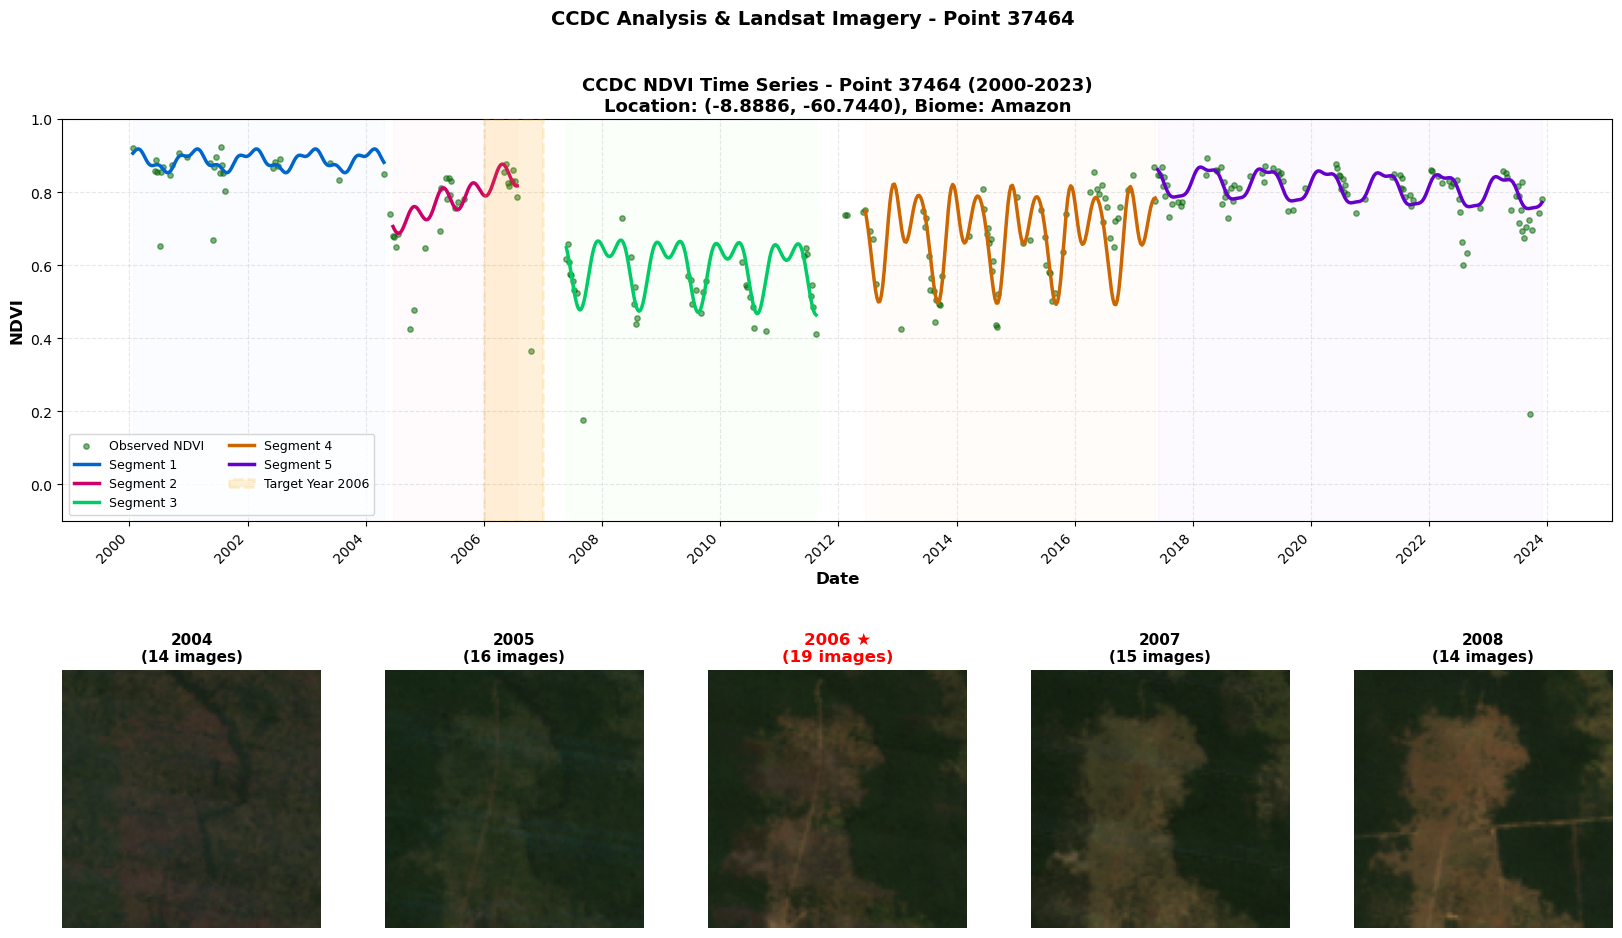


CCDC Segment Statistics:
Segment 1: 2000-01-22 to 2004-04-22 (1552 days, 101 obs, mean NDVI: 0.854, RMSE: 0.178)
Segment 2: 2004-06-17 to 2006-07-25 (768 days, 63 obs, mean NDVI: 0.756, RMSE: 0.187)
Segment 3: 2007-05-25 to 2011-08-16 (1543 days, 113 obs, mean NDVI: 0.532, RMSE: 0.097)
Segment 4: 2012-06-15 to 2017-05-12 (1792 days, 150 obs, mean NDVI: 0.662, RMSE: 0.082)
Segment 5: 2017-05-28 to 2023-11-29 (2375 days, 230 obs, mean NDVI: 0.794, RMSE: 0.109)

Target Year 2006:
  Observations: 28
  Mean NDVI (observed): 0.783
  Mean NDVI (fitted): 0.392
  RMSE: 0.290


In [ ]:
# Complete CCDC Analysis with Landsat Imagery Visualization
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import math
import pandas as pd

# ======================= USER INPUTS =======================
point_id = 37464  # Replace with your point ID
target_year = 2006  # Replace with your target year
start_year = 2000
end_year = 2022
# ===========================================================

# CCDC parameters
BREAKPOINT_BANDS = ['GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']
TMASK_BANDS = ['GREEN', 'SWIR2']
CCDC_DATE_FORMAT = 1  # fractional years
CCDC_LAMBDA = 20 / 10000.0
CCDC_MAX_ITER = 10000

print(f"{'='*80}")
print(f"CCDC Analysis + Landsat Imagery - Point {point_id}")
print(f"{'='*80}\n")

# Get point coordinates
point_data = df_points[df_points['TARGETID'] == point_id]
if len(point_data) == 0:
    print(f"Point ID {point_id} not found in validation data.")
else:
    point = point_data.iloc[0]
    lat = point['LAT']
    lon = point['LON']
    biome = point.get('BIOMA_250K', 'Unknown')
    
    print(f"Point ID: {point_id}")
    print(f"Location: Lat {lat:.4f}, Lon {lon:.4f}")
    print(f"Biome: {biome}")
    
    ee_point = ee.Geometry.Point([lon, lat])
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    
    # Helper functions
    def add_ndvi_band(image):
        ndvi = image.normalizedDifference(['NIR', 'RED']).rename('NDVI')
        return image.addBands(ndvi)
    
    def convert_date_to_fractional_year(date):
        year = ee.Number(date.get('year'))
        fractional = date.difference(ee.Date.fromYMD(year, 1, 1), 'year')
        return year.add(fractional)
    
    def date_to_segment(t, fits):
        t_start = ee.Array(fits.get('tStart'))
        t_end = ee.Array(fits.get('tEnd'))
        mask = t_start.lte(t).And(t_end.gte(t))
        return ee.List(mask.toList()).indexOf(1)
    
    def harmonic_fit(t, coef):
        pi2 = 2.0 * math.pi
        omega = pi2
        return (
            coef.get([0])
            .add(coef.get([1]).multiply(t))
            .add(coef.get([2]).multiply(t.multiply(omega).cos()))
            .add(coef.get([3]).multiply(t.multiply(omega).sin()))
            .add(coef.get([4]).multiply(t.multiply(omega * 2).cos()))
            .add(coef.get([5]).multiply(t.multiply(omega * 2).sin()))
            .add(coef.get([6]).multiply(t.multiply(omega * 3).cos()))
            .add(coef.get([7]).multiply(t.multiply(omega * 3).sin()))
        )
    
    def fractional_year_to_datetime(value):
        if value is None:
            return None
        year = int(math.floor(value))
        frac = value - year
        start = datetime(year, 1, 1)
        end = datetime(year + 1, 1, 1)
        return start + (end - start) * frac
    
    # Prepare Landsat collections
    print(f"\nPreparing Landsat collections ({start_year}-{end_year})...")
    
    standard_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']
    
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(ee_point) \
        .map(prepareL4L5L7Col2) \
        .map(add_ndvi_band) \
        .select(standard_bands)
    
    l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(ee_point) \
        .map(prepareL4L5L7Col2) \
        .map(add_ndvi_band) \
        .select(standard_bands)
    
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(ee_point) \
        .map(prepareL8Col2) \
        .map(add_ndvi_band) \
        .select(standard_bands)
    
    collection = l5.merge(l7).merge(l8)
    n_imgs = collection.size().getInfo()
    print(f"Total images: {n_imgs}")
    
    if n_imgs == 0:
        print("No images available for analysis")
    else:
        # Run CCDC algorithm
        print("Running CCDC algorithm...")
        ccdc_params = {
            'collection': collection,
            'breakpointBands': BREAKPOINT_BANDS,
            'tmaskBands': TMASK_BANDS,
            'dateFormat': CCDC_DATE_FORMAT,
            'lambda': CCDC_LAMBDA,
            'maxIterations': CCDC_MAX_ITER,
            'minObservations': 6,
            'chiSquareProbability': 0.99,
            'minNumOfYearsScaler': 1.33
        }
        ccdc_result = ee.Algorithms.TemporalSegmentation.Ccdc(**ccdc_params)
        
        projection = ee.Projection('EPSG:4326').atScale(30)
        fits = ee.Dictionary(ccdc_result.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=ee_point,
            crs=projection
        ))
        
        # Augment collection with fit values
        def augment_with_fit(img):
            img = ee.Image(img)
            time = convert_date_to_fractional_year(img.date())
            segment = date_to_segment(time, fits)
            value = img.select('NDVI').reduceRegion(
                ee.Reducer.first(), geometry=ee_point, crs=projection).get('NDVI')
            coef = ee.Algorithms.If(
                ee.Number(segment).add(1),
                ee.Array(fits.getArray('NDVI_coefs')).slice(0, segment, ee.Number(segment).add(1)).project([1]),
                ee.Array([0, 0, 0, 0, 0, 0, 0, 0])
            )
            fit = harmonic_fit(time, ee.Array(coef))
            return img.set({
                'value': value, 'fitTime': time, 'fit': fit,
                'segment': segment, 'dateString': img.date().format('YYYY-MM-dd')
            })
        
        series = collection.sort('system:time_start').map(augment_with_fit)
        
        print("Extracting time series data...")
        reducer = ee.Reducer.toList(4, 4)
        table = ee.List(series.reduceColumns(reducer, ['dateString', 'value', 'fit', 'segment']).get('list')).getInfo()
        
        df_ccdc = pd.DataFrame(table, columns=['date', 'ndvi', 'fit', 'segment'])
        df_ccdc['date'] = pd.to_datetime(df_ccdc['date'])
        df_ccdc = df_ccdc.sort_values('date')
        
        # Extract segments
        t_start = ee.Array(fits.get('tStart')).toList().getInfo()
        t_end = ee.Array(fits.get('tEnd')).toList().getInfo()
        segments = []
        for i, (start_val, end_val) in enumerate(zip(t_start, t_end)):
            if start_val is not None and end_val is not None:
                start_dt = fractional_year_to_datetime(start_val)
                end_dt = fractional_year_to_datetime(end_val)
                if start_dt and end_dt and end_dt > start_dt:
                    segments.append((i, start_dt, end_dt))
        
        print(f"Found {len(segments)} CCDC segments\n")
        
        # ==================== CREATE COMBINED PLOT ====================
        fig = plt.figure(figsize=(20, 11))
        gs = fig.add_gridspec(2, 5, height_ratios=[1.2, 1], hspace=0.3, wspace=0.25)
        
        # CCDC Plot (top row, spanning all columns)
        ax = fig.add_subplot(gs[0, :])
        
        # Plot observed NDVI
        ax.scatter(df_ccdc['date'], df_ccdc['ndvi'], s=15, color='darkgreen', 
                   alpha=0.5, label='Observed NDVI', zorder=2)
        
        # Plot harmonic curves for each segment
        segment_colors_line = ['#0066cc', '#cc0066', '#00cc66', '#cc6600', '#6600cc', '#cc9900']
        segment_colors_bg = ['#e6f2ff', '#ffe6f2', '#e6ffe6', '#fff2e6', '#f2e6ff', '#fff9e6']
        
        for seg_idx, start_dt, end_dt in segments:
            # Background color
            color_bg = segment_colors_bg[seg_idx % len(segment_colors_bg)]
            ax.axvspan(start_dt, end_dt, alpha=0.2, color=color_bg, zorder=1)
            
            # Generate dense time points for smooth curve
            n_points = 200
            time_range = pd.date_range(start=start_dt, end=end_dt, periods=n_points)
            
            # Convert to fractional years
            fractional_times = []
            for t in time_range:
                year = t.year
                year_start = datetime(year, 1, 1)
                year_end = datetime(year + 1, 1, 1)
                frac = (t - year_start) / (year_end - year_start)
                fractional_times.append(year + frac)
            
            # Get coefficients and calculate harmonic fit
            try:
                coefs_array = ee.Array(fits.getArray('NDVI_coefs')).slice(0, seg_idx, seg_idx + 1).project([1]).getInfo()
                pi2 = 2.0 * math.pi
                omega = pi2
                
                fit_values = []
                for t in fractional_times:
                    fit_val = (
                        coefs_array[0] + coefs_array[1] * t +
                        coefs_array[2] * np.cos(omega * t) +
                        coefs_array[3] * np.sin(omega * t) +
                        coefs_array[4] * np.cos(2 * omega * t) +
                        coefs_array[5] * np.sin(2 * omega * t) +
                        coefs_array[6] * np.cos(3 * omega * t) +
                        coefs_array[7] * np.sin(3 * omega * t)
                    )
                    fit_values.append(fit_val)
                
                color = segment_colors_line[seg_idx % len(segment_colors_line)]
                ax.plot(time_range, fit_values, color=color, linewidth=2.5, 
                       label=f'Segment {seg_idx + 1}' if seg_idx < 6 else None, zorder=3)
            except Exception as e:
                print(f"Warning: Could not plot segment {seg_idx + 1}: {e}")
        
        # Highlight target year
        if target_year:
            target_start_dt = datetime(target_year, 1, 1)
            target_end_dt = datetime(target_year, 12, 31)
            ax.axvspan(target_start_dt, target_end_dt, alpha=0.15, color='orange', 
                      edgecolor='red', linewidth=2, linestyle='--',
                      label=f'Target Year {target_year}', zorder=4)
        
        ax.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax.set_ylabel('NDVI', fontsize=12, fontweight='bold')
        ax.set_title(f'CCDC NDVI Time Series - Point {point_id} ({start_year}-{end_year})\n'
                    f'Location: ({lat:.4f}, {lon:.4f}), Biome: {biome}', 
                    fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_ylim([-0.1, 1.0])
        ax.legend(loc='best', fontsize=9, ncol=2)
        
        import matplotlib.dates as mdates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Landsat RGB imagery (bottom row)
        print("Fetching Landsat RGB imagery...")
        buffer_distance = 1500
        roi = ee_point.buffer(buffer_distance).bounds()
        imagery_years = [target_year - 2, target_year - 1, target_year, target_year + 1, target_year + 2]
        
        for idx, year in enumerate(imagery_years):
            ax_img = fig.add_subplot(gs[1, idx])
            
            try:
                if year < 2013:
                    img_collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                        .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')) \
                        .filterDate(f'{year}-01-01', f'{year}-12-31') \
                        .filterBounds(ee_point) \
                        .filter(ee.Filter.lt('CLOUD_COVER', 30))
                    rgb_bands = ['SR_B3', 'SR_B2', 'SR_B1']
                else:
                    img_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                        .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')) \
                        .filterDate(f'{year}-01-01', f'{year}-12-31') \
                        .filterBounds(ee_point) \
                        .filter(ee.Filter.lt('CLOUD_COVER', 30))
                    rgb_bands = ['SR_B4', 'SR_B3', 'SR_B2']
                
                n_imgs = img_collection.size().getInfo()
                
                if n_imgs > 0:
                    img = img_collection.median().select(rgb_bands).multiply(0.0000275).add(-0.2)
                    url = img.getThumbURL({
                        'region': roi.getInfo()['coordinates'],
                        'dimensions': 100, 'format': 'png',
                        'min': 0, 'max': 0.3
                    })
                    
                    import requests
                    from PIL import Image
                    from io import BytesIO
                    
                    response = requests.get(url)
                    img_data = Image.open(BytesIO(response.content))
                    ax_img.imshow(img_data)
                    
                    if year == target_year:
                        ax_img.set_title(f'{year} ★\n({n_imgs} images)', 
                                       fontsize=12, fontweight='bold', color='red')
                        for spine in ax_img.spines.values():
                            spine.set_edgecolor('red')
                            spine.set_linewidth(3)
                    else:
                        ax_img.set_title(f'{year}\n({n_imgs} images)', fontsize=11, fontweight='bold')
                    ax_img.axis('off')
                    print(f"  {year}: ✓ ({n_imgs} images)")
                else:
                    ax_img.text(0.5, 0.5, f'No imagery\n({year})', 
                               ha='center', va='center', fontsize=10, transform=ax_img.transAxes)
                    ax_img.set_title(f'{year}', fontsize=11, fontweight='bold')
                    ax_img.axis('off')
                    print(f"  {year}: No imagery")
            except Exception as e:
                ax_img.text(0.5, 0.5, f'Error\n{year}', 
                           ha='center', va='center', fontsize=10, transform=ax_img.transAxes)
                ax_img.set_title(f'{year}', fontsize=11, fontweight='bold')
                ax_img.axis('off')
                print(f"  {year}: Error")
        
        plt.suptitle(f'CCDC Analysis & Landsat Imagery - Point {point_id}', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.show()
        
        # Print segment statistics
        print(f"\n{'='*80}")
        print("CCDC Segment Statistics:")
        print(f"{'='*80}")
        for idx, start_dt, end_dt in segments:
            duration_days = (end_dt - start_dt).days
            segment_data = df_ccdc[(df_ccdc['date'] >= start_dt) & (df_ccdc['date'] <= end_dt)]
            if len(segment_data) > 0:
                mean_ndvi = segment_data['ndvi'].mean()
                rmse = np.sqrt(((segment_data['ndvi'] - segment_data['fit']) ** 2).mean())
                print(f"Segment {idx + 1}: {start_dt.strftime('%Y-%m-%d')} to {end_dt.strftime('%Y-%m-%d')} "
                      f"({duration_days} days, {len(segment_data)} obs, mean NDVI: {mean_ndvi:.3f}, RMSE: {rmse:.3f})")
        
        if target_year:
            target_data = df_ccdc[df_ccdc['date'].dt.year == target_year]
            if len(target_data) > 0:
                print(f"\nTarget Year {target_year}:")
                print(f"  Observations: {len(target_data)}")
                print(f"  Mean NDVI (observed): {target_data['ndvi'].mean():.3f}")
                print(f"  Mean NDVI (fitted): {target_data['fit'].mean():.3f}")
                print(f"  RMSE: {np.sqrt(((target_data['ndvi'] - target_data['fit']) ** 2).mean()):.3f}")
        print(f"{'='*80}")
